### Importing Libraries

In [66]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import cv2 as cv2
import scipy as sp

from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [41]:
source_path = 'C:/Users/alasmar/Downloads/cats-vs-dogs/PetImages'
source_path_cats = os.path.join(source_path, 'Cat')

source_path_dogs = os.path.join(source_path, 'Dog')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


### Data Preprocessing

In [72]:
#Define data path
CAT_DIR = 'C:/Users/alasmar/Downloads/cats-vs-dogs/PetImages/Cat'
DOG_DIR = 'C:/Users/alasmar/Downloads/cats-vs-dogs/PetImages/Dog'

#try:
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs')
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs/training')
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs/validation')
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs/training/cats')
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs/training/dogs')
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs/validation/cats')
    #os.mkdir('C:/Users/alasmar/Downloads/cats-v-dogs/validation/dogs')
#except OSError:
    #print('Error failed to make directory')

##### Let's check the distribution of the data

In [42]:
class_names = ['Cat', 'Dog'] 

n_cats = len(os.listdir('C:/Users/alasmar/Downloads/cats-vs-dogs/PetImages/Cat'))

n_dogs = len(os.listdir('C:/Users/alasmar/Downloads/cats-vs-dogs/PetImages/Dog'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

##### Now let's create directories for training and validation

In [43]:
TRAINING_DIR = "C:/Users/alasmar/Downloads/cats-v-dogs/training/"
VALIDATION_DIR = "C:/Users/alasmar/Downloads/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

##### The data is perfectly balanced

##### Now let's create a function to split the data

In [45]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
   
    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

##### Now let's call the function to create the training/validation data

In [ ]:
split_data(CAT_DIR, 'C:/Users/alasmar/Downloads/cats-v-dogs/training/cats','C:/Users/alasmar/Downloads/cats-v-dogs/validation/cats', 0.9)
split_data(DOG_DIR, 'C:/Users/alasmar/Downloads/cats-v-dogs/training/dogs', 'C:/Users/alasmar/Downloads/cats-v-dogs/validation/dogs', 0.9)

#### Create Generators

In [47]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)

In [48]:
train_generator = train_gen.flow_from_directory(
        'C:/Users/alasmar/Downloads/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        'C:/Users/alasmar/Downloads/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        'C:/Users/alasmar/Downloads/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 24756 images belonging to 2 classes.
Found 4752 images belonging to 2 classes.
Found 4752 images belonging to 2 classes.


##### Now let's visualize the data

In [49]:
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

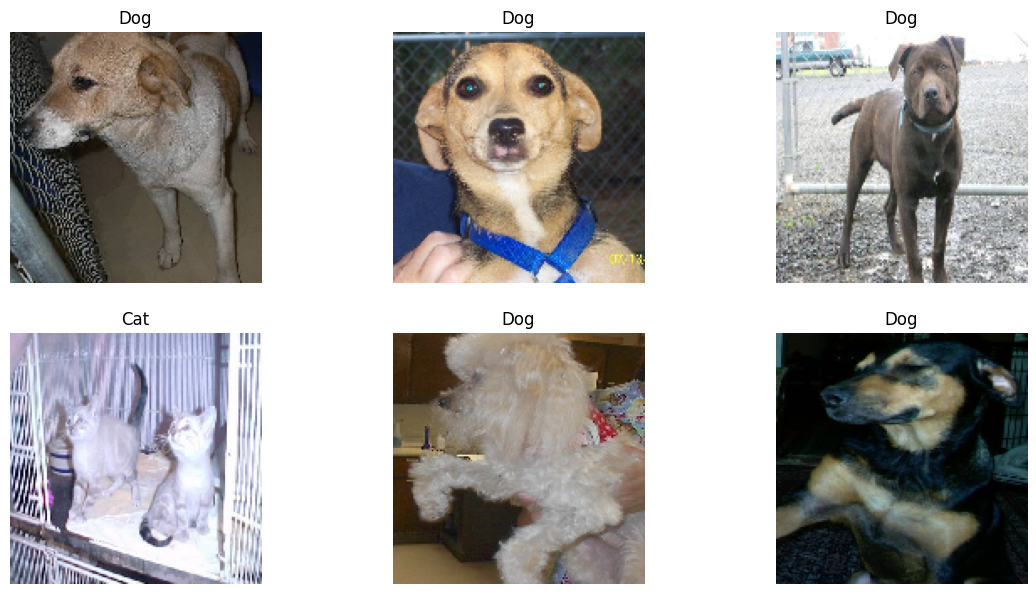

In [50]:
plot_data(train_generator,7)

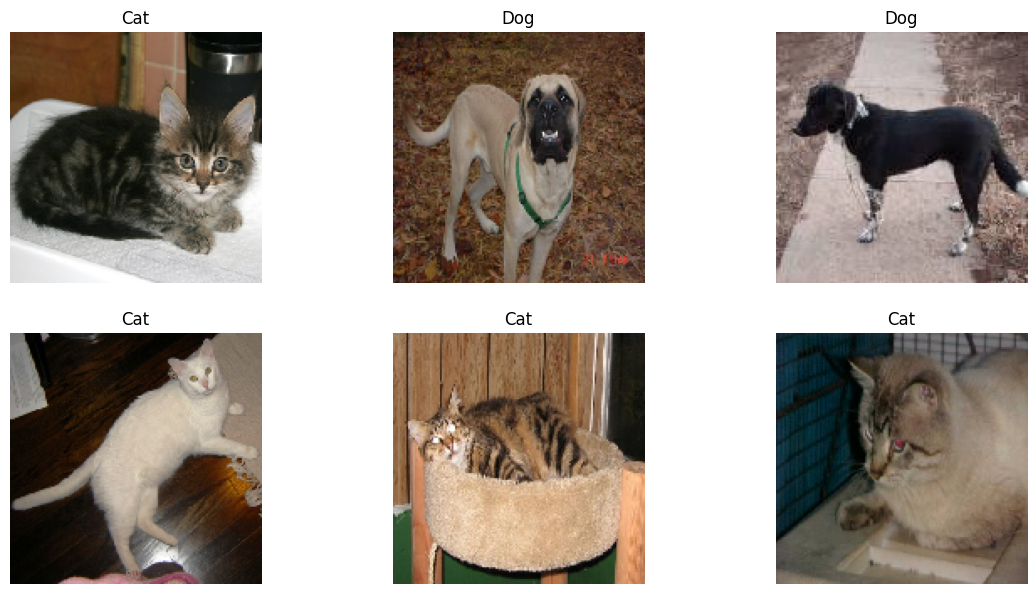

In [51]:
plot_data(validation_generator,7)

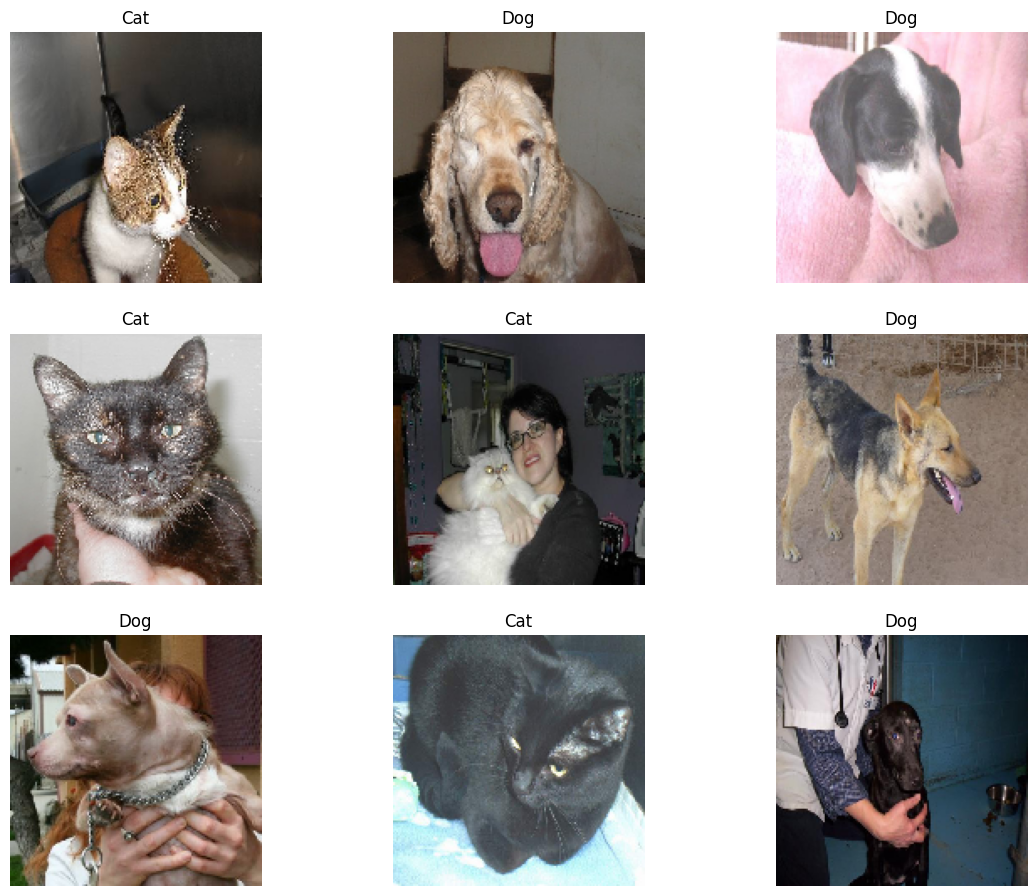

In [52]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

##### Great, now that the data is ready let's train our model

## Model Implementations

In [53]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)

In [54]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [30]:
r = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

Epoch 1/10
 49/387 [==>...........................] - ETA: 37:41 - loss: 0.7401 - accuracy: 0.4882

C:\Users\alasmar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning:

Truncated File Read



387/387 [==============================] - 2375s 6s/step - loss: 0.6999 - accuracy: 0.5453 - val_loss: 0.6665 - val_accuracy: 0.5810
Epoch 2/10
387/387 [==============================] - 2121s 5s/step - loss: 0.6593 - accuracy: 0.6104 - val_loss: 0.6361 - val_accuracy: 0.6258
Epoch 3/10
387/387 [==============================] - 2064s 5s/step - loss: 0.6223 - accuracy: 0.6605 - val_loss: 0.5914 - val_accuracy: 0.6963
Epoch 4/10
387/387 [==============================] - 2056s 5s/step - loss: 0.6007 - accuracy: 0.6849 - val_loss: 0.5837 - val_accuracy: 0.6888
Epoch 5/10
387/387 [==============================] - 2107s 5s/step - loss: 0.5823 - accuracy: 0.6989 - val_loss: 0.5278 - val_accuracy: 0.7576
Epoch 6/10
387/387 [==============================] - 1962s 5s/step - loss: 0.5593 - accuracy: 0.7156 - val_loss: 0.5216 - val_accuracy: 0.7471
Epoch 7/10
387/387 [==============================] - 1976s 5s/step - loss: 0.5403 - accuracy: 0.7363 - val_loss: 0.4653 - val_accuracy: 0.8009
Epo

## Model Evaluation

##### Evaluate the model on the test set

In [55]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

20/75 [=======>......................] - ETA: 1:21 - loss: 0.6931 - accuracy: 0.5055

C:\Users\alasmar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning:

Truncated File Read



75/75 [==============================] - 111s 1s/step - loss: 0.6931 - accuracy: 0.5293


#### Visualize the predicitons

In [56]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

2/2 [==============================] - 2s 747ms/step


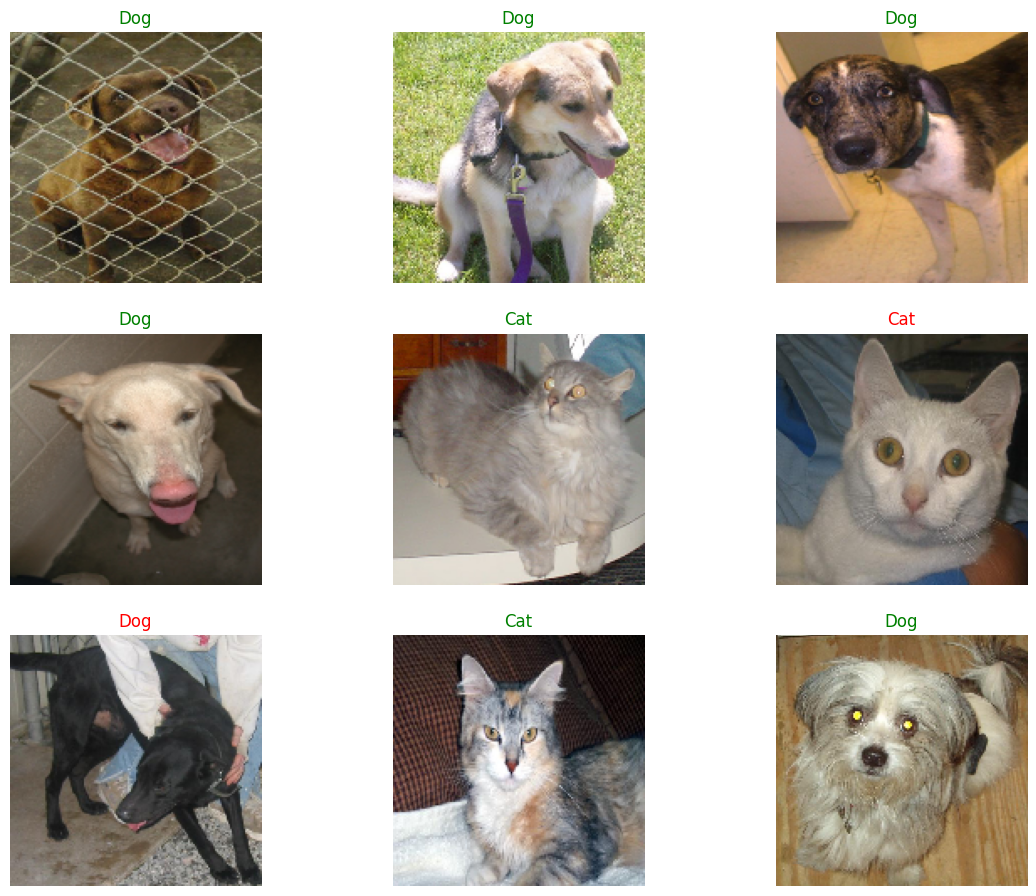

In [57]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

2/2 [==============================] - 2s 944ms/step


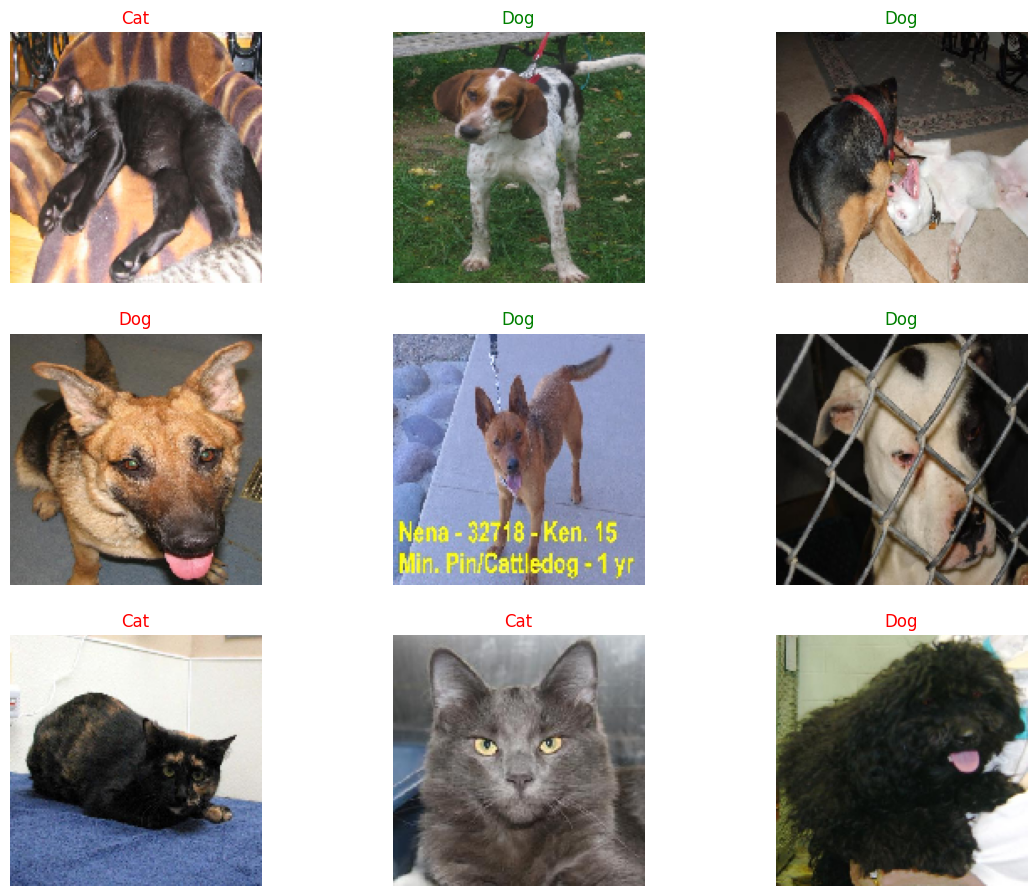

In [58]:
plot_prediction(validation_generator, 10)

#### Visualize the activation maps

In [61]:
# Create a  model to visualize activation maps
gp_weights =  model.get_layer('dense_4').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_105').output, model.get_layer('dense_5').output))

In [62]:
# Use the model to make predictions on the test generator
images, _ = test_generator.next()
features, results = activation_model.predict(images)

2/2 [==============================] - 2s 714ms/step


In [63]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image
    
    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [64]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated 
    '''
    counter = 0
    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

Predicted Class = Dog, Probability = 0.50037223


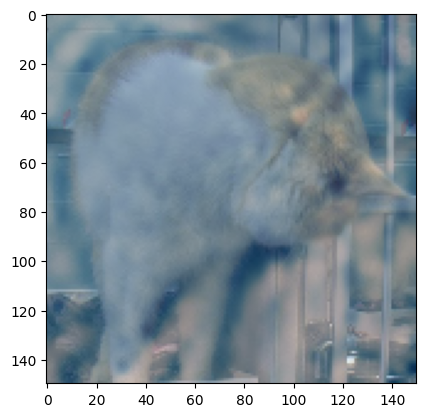

Predicted Class = Dog, Probability = 0.50014895


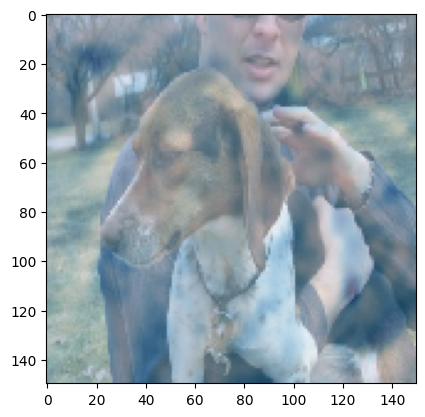

Predicted Class = Dog, Probability = 0.50022274


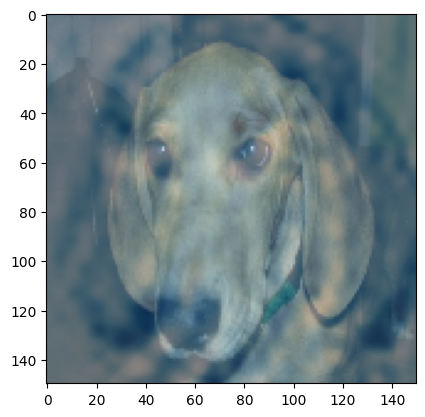

Predicted Class = Dog, Probability = 0.50003386


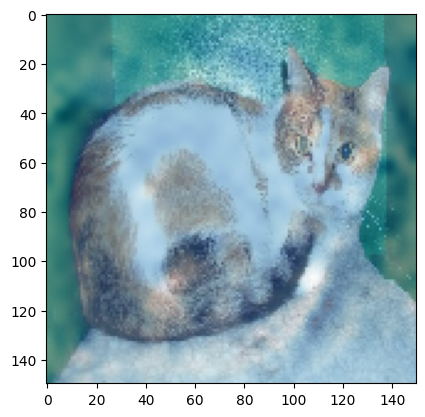

Predicted Class = Dog, Probability = 0.50023663


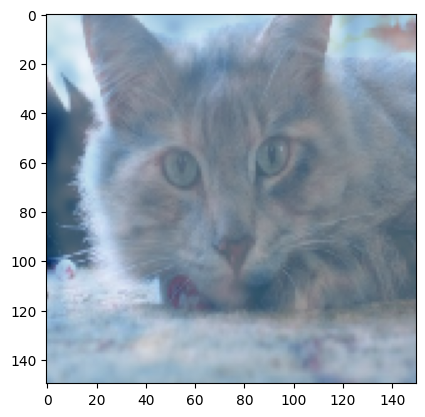

In [67]:
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.5000427


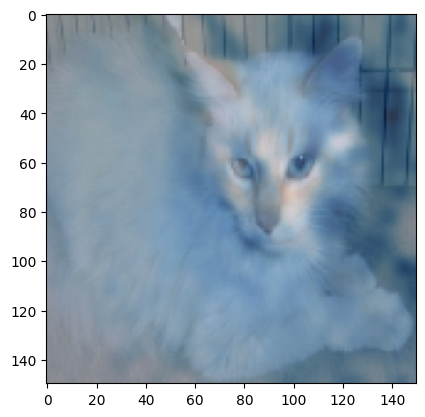

Predicted Class = Cat, Probability = 0.50009453


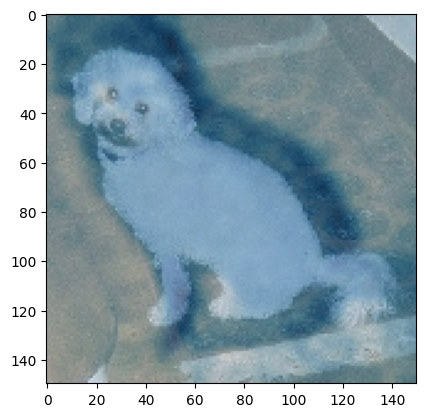

Predicted Class = Cat, Probability = 0.5000398


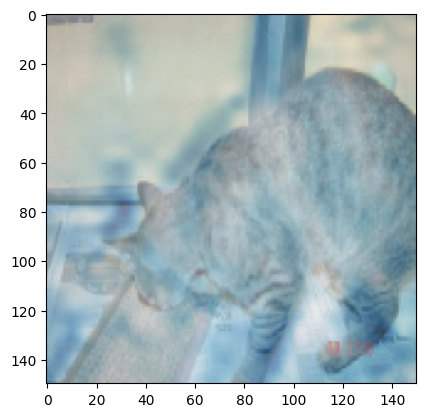

Predicted Class = Cat, Probability = 0.5000291


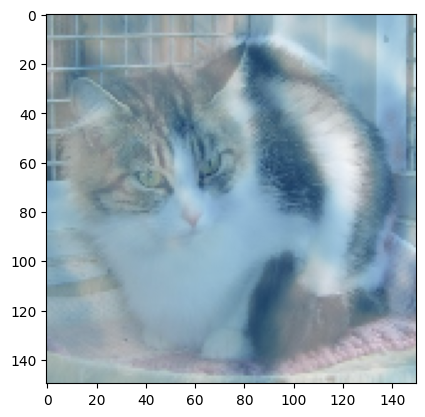

Predicted Class = Cat, Probability = 0.50010026


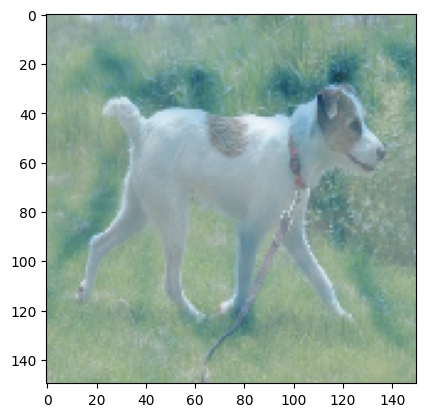

In [68]:
show_maps(desired_class=0, num_maps=5)

### Visualize training process

In [69]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  0.559308  0.715607  0.521627      0.747054
6  0.540277  0.736253  0.465331      0.800926
7  0.509015  0.758636  0.476790      0.783670
8  0.492312  0.769343  0.382370      0.834386
9  0.457667  0.789988  0.409212      0.820076

In [70]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [71]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

### We'll be using  InceptionV3

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator( rescale = 1.0/255. )
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('C:/Users/alasmar/Downloads/cats-v-dogs/training',
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     


validation_generator =  valid_datagen.flow_from_directory( 'C:/Users/alasmar/Downloads/cats-v-dogs/validation',
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 24751 images belonging to 2 classes.
Found 4752 images belonging to 2 classes.


In [33]:
test_gen =  ImageDataGenerator(
            rescale=1./255.)
test_generator = test_gen.flow_from_directory(
        'C:/Users/alasmar/Downloads/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 4752 images belonging to 2 classes.


In [12]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in inception.layers[:-10]:
    layer.trainable = False # Freeze weights of all layers till except the last 10
    
last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [13]:
x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inception.input, predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [14]:
def scheduler(epoch, lr):
    
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.2)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # set the callback to our scheduler function

In [15]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [16]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,callbacks=[callback])

Epoch 1/20
 69/387 [====>.........................] - ETA: 12:50 - loss: 0.4273 - accuracy: 0.8836

C:\Users\alasmar\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning:

Truncated File Read



387/387 [==============================] - 1076s 3s/step - loss: 0.3410 - accuracy: 0.9112 - val_loss: 0.1537 - val_accuracy: 0.9651 - lr: 1.0000e-04
Epoch 2/20
387/387 [==============================] - 1030s 3s/step - loss: 0.2720 - accuracy: 0.9280 - val_loss: 0.1810 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 3/20
387/387 [==============================] - 1021s 3s/step - loss: 0.2315 - accuracy: 0.9328 - val_loss: 0.1641 - val_accuracy: 0.9655 - lr: 1.0000e-04
Epoch 4/20
387/387 [==============================] - 1014s 3s/step - loss: 0.2244 - accuracy: 0.9388 - val_loss: 0.1257 - val_accuracy: 0.9724 - lr: 1.0000e-04
Epoch 5/20
387/387 [==============================] - 1030s 3s/step - loss: 0.1833 - accuracy: 0.9457 - val_loss: 0.1288 - val_accuracy: 0.9754 - lr: 1.0000e-04
Epoch 6/20
387/387 [==============================] - 1040s 3s/step - loss: 0.1778 - accuracy: 0.9445 - val_loss: 0.1119 - val_accuracy: 0.9758 - lr: 1.0000e-04
Epoch 7/20
387/387 [=========================

### Evaluation


#### View predictions

2/2 [==============================] - 3s 534ms/step


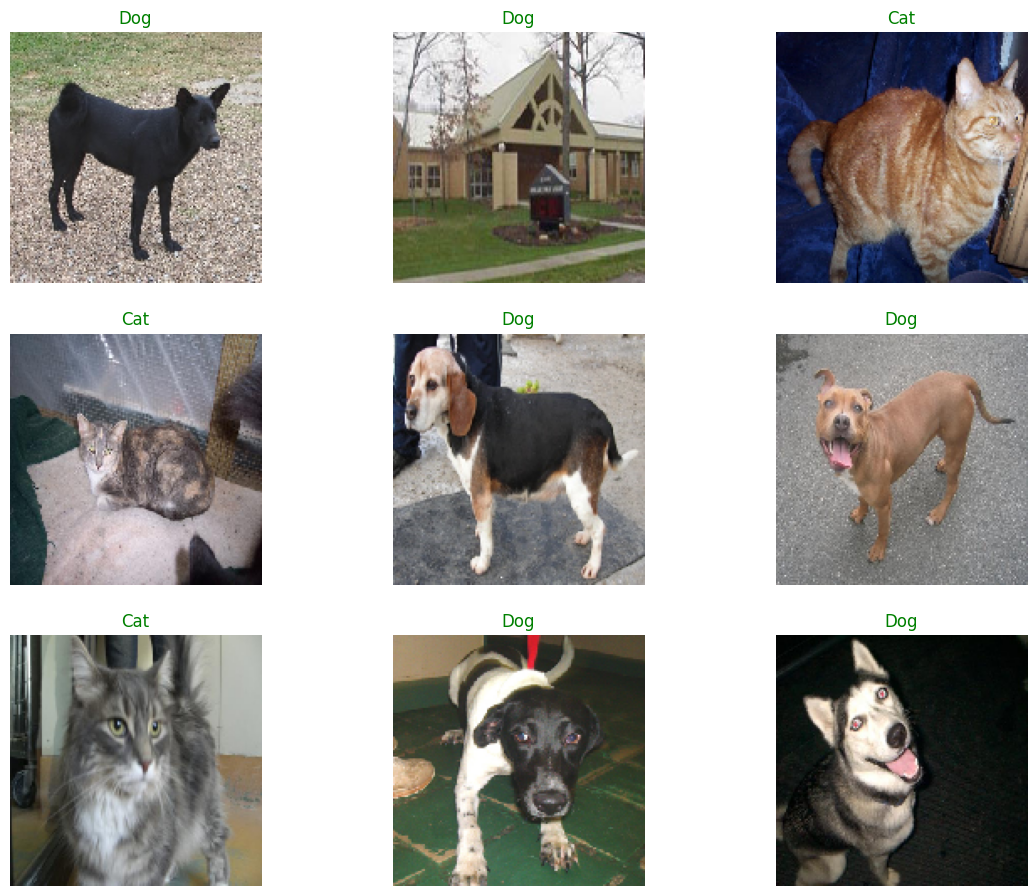

In [18]:
plot_prediction(validation_generator, 10)

### View saliency map

##### Saliency activation maps is used to find which parts the model was paying attention to while classifying the image

In [19]:
images, labels =  validation_generator.next()

In [20]:
def calculate_gradients(images, labels, index):
    """
    Computes gradient of the loss with respect to the input image
    
    Args:
    Images: numpy array containing images of shape (n,150,150,3)
    labels: numpy array containing labels shape(n,)
    index: index of the image
    """
    # get image of the given index and add 1 to it's first dimension
    image = np.expand_dims(images[index],axis=0)
    #convert image to tensor
    image_tensor = tf.convert_to_tensor(image)
    # get the class of the given label and convert it to an integer
    class_index = int(labels[index])
    # one hot encode the labels 
    true_value = tf.one_hot([class_index] * image.shape[0], 2)

    # compute the gradient of the loss
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image_tensor)
        # Generate predictions
        pred  = model(image_tensor)
        # Compute loss
        loss = tf.keras.losses.categorical_crossentropy(true_value, pred)
    # Get the gradient with respect to the image
    gradients = tape.gradient(loss, image_tensor)
    
    grey_scale_gradients = tf.reduce_sum(tf.abs(gradients),axis=-1)
    normalized_gradients = (255*(grey_scale_gradients - tf.reduce_min(grey_scale_gradients))/
                           (tf.reduce_max(grey_scale_gradients) - tf.reduce_min(grey_scale_gradients)))
    
    normalized_gradients = tf.squeeze(normalized_gradients)
    normalized_gradients = tf.cast(normalized_gradients, tf.uint8)
    return normalized_gradients,pred

In [21]:
def show_saliency(images, labels, n_images):
    """
    plot saliency maps
    Args:
    Images: numpy array containing images of shape (n,150,150,3)
    labels: numpy array containing labels shape(n,)
    n_images: number of images to plot
    """
    # Loop for number of images specified
    for i in range(n_images):
        # Computes gradient of the loss with respect to the input image
        gradients,prediction = calculate_gradients(images, labels, i)
        prediction = np.argmax(prediction)
        # Colorize greyscale gradients
        gradient_color = cv2.applyColorMap(gradients.numpy(), cv2.COLORMAP_HOT)
        #Normalize the colored gradients
        gradient_color = gradient_color / 255.0
        # Super impose colored gradients on the image
        super_imposed = cv2.addWeighted(images[i], 0.6, gradient_color, 0.5, 0.1, dtype = cv2.CV_64F)
        print('Predicted Class: ' +str(class_names[prediction]+",\t"+ f'True Class: {class_names[int(labels[i])]}'))
        plt.figure(figsize=(8, 8))
        plt.imshow(super_imposed)
        plt.axis('off')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: Dog,	True Class: Dog


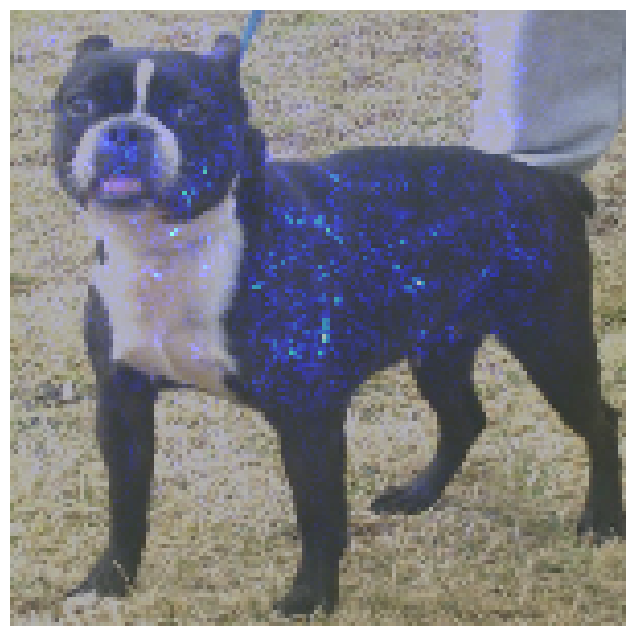

Predicted Class: Dog,	True Class: Dog


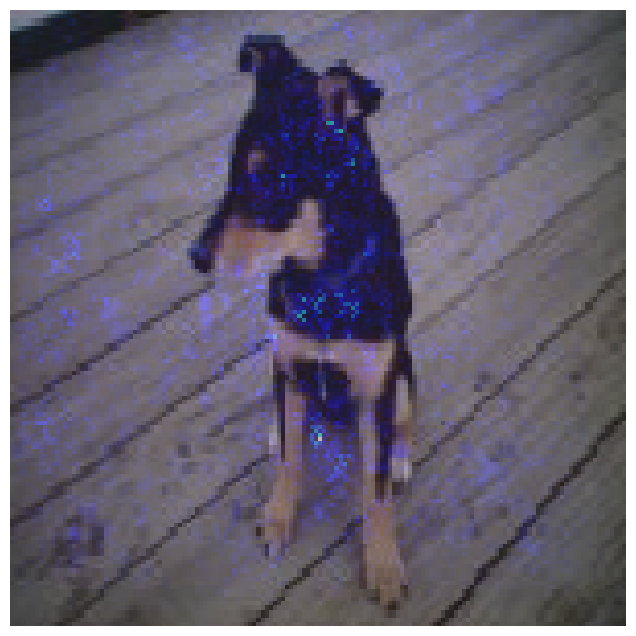

Predicted Class: Cat,	True Class: Cat


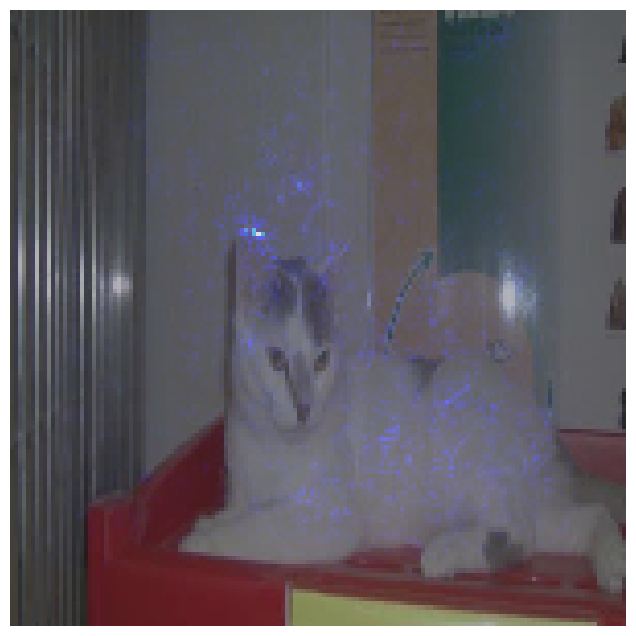

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: Dog,	True Class: Dog


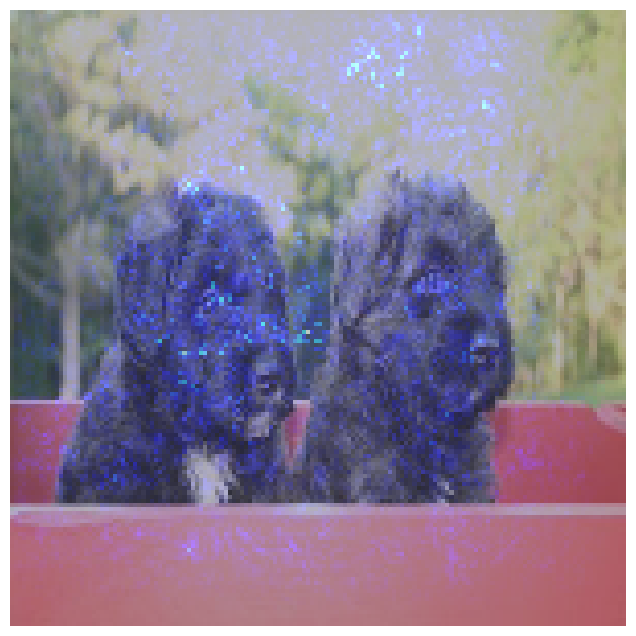

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: Dog,	True Class: Dog


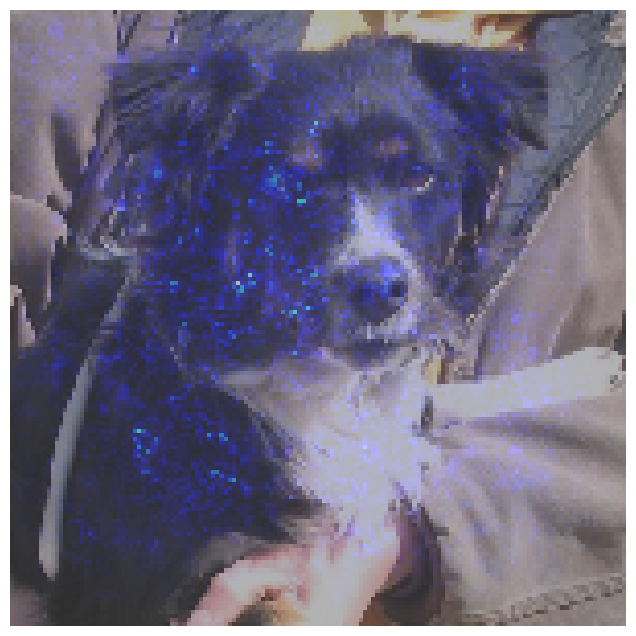

In [22]:
show_saliency(images, labels, 5)

### View training process

In [23]:
results = pd.DataFrame(history.history)
results.tail()

loss  accuracy  val_loss  val_accuracy      lr
15  0.132908  0.954184  0.072333      0.981902  0.0001
16  0.121852  0.956406  0.069356      0.982744  0.0001
17  0.131419  0.955355  0.070795      0.983586  0.0001
18  0.125062  0.956406  0.073205      0.984428  0.0001
19  0.130948  0.954790  0.070022      0.982744  0.0001

In [24]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(   
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title='Epochs'), 
    yaxis=dict(color="#41BEE9")
 )
fig.show()

In [25]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(   
    title_font_color="#41BEE9", 
    xaxis=dict(color="#41BEE9",title='Epochs'), 
    yaxis=dict(color="#41BEE9")
 )
fig.show()

## Conclusion

##### We were able to achieve 95 training accuracy and 98 validation accuracy
##### This seems much better than the original results from the simple CNN